## Sample catchments

In [4]:
import os
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import shutil
import pandas as pd
import math

### Map of all catchments

In [5]:
# Define the folder path
folder_path = 'data/catchments/processed/'

# Define the output file path
output_file_path = 'data/catchments/catchment_coordinates_all.txt'

# Open the output file in append mode
with open(output_file_path, "w") as outfile:
    outfile.write("GRDC,latitude,longitude,catchment_area\n")  # Write header to the output file

    # Loop through all files in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"):  # Check if the file is a text file
            file_path = os.path.join(folder_path, filename)
            with open(file_path, "r", encoding="windows-1252") as file:
                lines = file.readlines()
                latitude_line = lines[12].strip().split(":")[1].strip()
                longitude_line = lines[13].strip().split(":")[1].strip()
                area_line = lines[14].strip().split(":")[1].strip()

            # Extract GRDC number from filename
            grdc_number = filename.split("_")[0]

            # Check if catchment area is above 300
            if float(area_line) < 300 and 4.75 <= float(longitude_line) <= 15.25 and 44.75 <= float(latitude_line) <= 55.25:
                # Write latitude, longitude, and GRDC number to the output file
                outfile.write("{},{},{},{}\n".format(grdc_number, latitude_line, longitude_line, area_line))

# Print message indicating completion
print("Latitude and longitude saved to", output_file_path)


Latitude and longitude saved to data/catchments/catchment_coordinates_all.txt


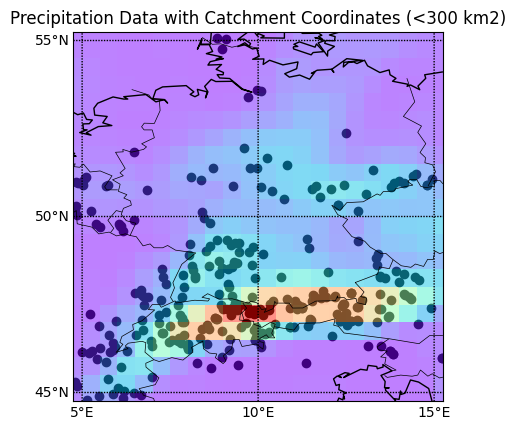

In [7]:
# File paths
precipitation_file = "data/total_precipitation/tp.daily.calc.era5.0d50_CentralEurope.2000.nc"
coordinates_file = "data/catchments/catchment_coordinates_all.txt"

# Open the NetCDF file
nc_file = nc.Dataset(precipitation_file)
lon = nc_file.variables['lon'][:]
lat = nc_file.variables['lat'][:]
data = nc_file.variables['tp'][50, :, :]  # Using arbitrary time index 100

# Create Basemap instance
m = Basemap(llcrnrlon=lon.min(), llcrnrlat=lat.min(),
            urcrnrlon=lon.max(), urcrnrlat=lat.max(),
            projection='cyl', resolution='l')

# Draw coastlines, countries, and states
m.drawcoastlines()
m.drawcountries()
m.drawstates()

# Convert lat/lon values to x/y coordinates for catchment points
catchment_data = np.genfromtxt(coordinates_file, delimiter=',', skip_header=1, dtype=str)
catchment_lat = catchment_data[:, 1].astype(float)
catchment_lon = catchment_data[:, 2].astype(float)
x_catchment, y_catchment = m(catchment_lon, catchment_lat)

# Overlay catchment coordinates in black
plt.scatter(x_catchment, y_catchment, c='black', marker='o', label='Catchment Coordinates')

# Plot the precipitation data as grid cells
x_mesh, y_mesh = np.meshgrid(lon, lat)
x_mesh, y_mesh = m(x_mesh, y_mesh)
plt.pcolormesh(x_mesh, y_mesh, data, cmap='rainbow', alpha=0.5, label='Precipitation Data')

# Add latitude and longitude lines with labels
m.drawparallels(np.arange(-90., 91., 5.), labels=[1,0,0,0], fontsize=10)
m.drawmeridians(np.arange(-180., 181., 5.), labels=[0,0,0,1], fontsize=10)

plt.title('Precipitation Data with Catchment Coordinates (<300 km2)')

# Show the plot
plt.show()

# Close the NetCDF file
nc_file.close()

### Select and map random sample (n = 50)

Before we do the catchment sample, we decide to filter the data further. Here we select all catchment, which have runoff data at least from 1999 to 2017.

In [11]:
# Define the folder path
folder_path = 'data/catchments/processed/'

# Define the destination file path
destination_file_path = 'data/catchments/catchment_coordinates_date.txt'

# Initialize counter for extracted files
extracted_files_count = 0

# Open the destination file in write mode
with open(destination_file_path, "w") as outfile:
    # Write the header to the output file
    outfile.write("GRDC,latitude,longitude,catchment_area,start_date,end_date\n")

    # Loop through all files in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"):  # Check if the file is a text file
            file_path = os.path.join(folder_path, filename)

            with open(file_path, "r", encoding="windows-1252") as file:
                lines = file.readlines()
                # Extract latitude, longitude, and catchment area from specific lines
                latitude_line = [line.strip().split(":")[1].strip() for line in lines if "Latitude" in line][0]
                longitude_line = [line.strip().split(":")[1].strip() for line in lines if "Longitude" in line][0]
                area_line = [line.strip().split(":")[1].strip() for line in lines if "Catchment area" in line][0]
                time_series_line = [line.strip().split(":")[1].strip() for line in lines if "Time series" in line][0]
                date_start, date_end = time_series_line.split(" - ")

                # Splitting the date strings
                start_year, start_month = date_start.split("-")
                end_year, end_month = date_end.split("-")

                # Check if catchment area is above 300 and within specified latitude and longitude range
                if (float(area_line) < 300 and
                        4.75 <= float(longitude_line) <= 15.25 and
                        44.75 <= float(latitude_line) <= 55.25 and
                        int(start_year) < 1999 and int(end_year) > 2016):
                    # Write the data to the output file
                    outfile.write(f"{filename.split('.')[0]},{latitude_line},{longitude_line},{area_line},{date_start},{date_end}\n")
                    extracted_files_count += 1

# Print message indicating completion and number of extracted files
print("Data saved to", destination_file_path)
print("Number of extracted files:", extracted_files_count)


Data saved to data/catchments/catchment_coordinates_date.txt
Number of extracted files: 198


In [12]:
file_path = 'data/catchments/catchment_coordinates_date.txt'
coords_df = pd.read_csv(file_path)
print(coords_df)


              GRDC   latitude  longitude  catchment_area start_date end_date
0    6335620_Q_Day  49.345874   9.128615          156.00    1980-11  2021-12
1    6220310_Q_Day  51.004141   5.014040         -999.00    1986-10  2023-08
2    6242020_Q_Day  47.210000  10.140000           84.39    1951-01  2020-12
3    6935460_Q_Day  47.496300   8.953000           78.90    1914-01  2020-12
4    6935530_Q_Day  46.631300   7.899700          164.00    1933-01  2020-12
..             ...        ...        ...             ...        ...      ...
193  6335651_Q_Day  48.724098   8.897686          238.20    1952-11  2019-12
194  6545125_Q_Day  45.988500  15.230100          271.21    1992-01  2021-12
195  6421103_Q_Day  50.900000   5.740000         -999.00    1994-01  2018-12
196  6342960_Q_Day  48.816254  13.358568          113.30    1950-11  2021-12
197  6559130_Q_Day  46.155700  13.775700          142.31    1952-01  2021-12

[198 rows x 6 columns]


In [13]:
coords_df = coords_df[coords_df['catchment_area'] != -999]
south = coords_df[coords_df['latitude'] >= 50]
north = coords_df[coords_df['latitude'] < 50]

In [14]:
np.random.seed(18) # with random seed 18, we get a good distribution
# sample of 25 from above 50 and below 50 latitude, since the catchment points are not equally distributed
south_sample = south.sample(n=25, replace=False)
north_sample = north.sample(n=25, replace=False)
samples_df = pd.concat([south_sample, north_sample], ignore_index=True)

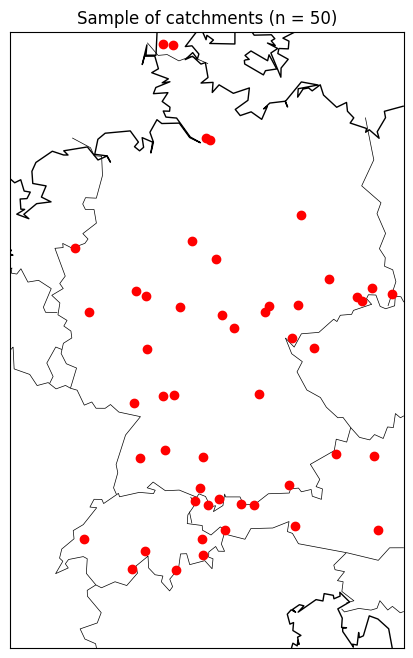

In [20]:
# Create a new figure
plt.figure(figsize=(10, 8))

# Create a Basemap instance centered at a desired location
m = Basemap(projection='merc', llcrnrlat=44.75, urcrnrlat=55.25,
            llcrnrlon=4.75, urcrnrlon=15.25, resolution='l')

# Draw coastlines, countries, and states
m.drawcoastlines()
m.drawcountries()
m.drawstates()

# Convert latitude and longitude to map coordinates
x, y = m(samples_df['longitude'].values, samples_df['latitude'].values)

# Plot the points on the map
m.scatter(x, y, marker='o', color='r', zorder=5)

# Add title and show the plot
plt.title('Sample of catchments (n = 50)')
plt.show()


Map from Kilian


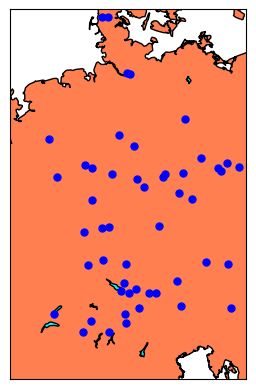

In [21]:
import folium

#make string numeric - but now there are nas
samples_df["longitude"] = pd.to_numeric(samples_df["longitude"], errors='coerce')
samples_df["latitude"] = pd.to_numeric(samples_df["latitude"], errors='coerce')

#drop nas
df = samples_df.dropna()

## interactive map
# Define the coordinates for the bounding box
bbox = [[44.75, 4.75], [55.25, 15.25]]

# Create a map centered at the middle of the bounding box
m = folium.Map(location=[(bbox[0][0] + bbox[1][0]) / 2, (bbox[0][1] + bbox[1][1]) / 2])

# Add a rectangle to the map to represent the bounding box
folium.Rectangle(
    bounds=bbox,
    color='#ff7800',
    fill=True,
    fill_color='#ffff00',
    fill_opacity=0.2
).add_to(m)

# Add points to the map
for lat, lon in zip(df["latitude"], df["longitude"]):
    folium.CircleMarker(
        location=[lat, lon],
        radius=5,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(m)

# Display the map
m

## static map
# Create a map centered at the middle of the bounding box
bbox = [[44.75, 4.75], [55.25, 15.25]]
m = Basemap(projection='merc', llcrnrlat=bbox[0][0], urcrnrlat=bbox[1][0], llcrnrlon=bbox[0][1], urcrnrlon=bbox[1][1], resolution='i')

m.drawcoastlines()
m.fillcontinents(color='coral',lake_color='aqua')

# Add points to the map
x, y = m(df["longitude"].values, df["latitude"].values)
m.plot(x, y, 'bo', markersize=5)

plt.show()

In [22]:
samples_df

,GRDC,latitude,longitude,catchment_area,start_date,end_date
0,6340612_Q_Day,51.164241,14.406338,275.90,1925-11,2017-12
1,6340366_Q_Day,50.889017,12.432924,293.00,1992-11,2020-12
2,6934870_Q_Day,55.047350,9.092970,103.00,1962-05,2022-12
3,6335035_Q_Day,51.108870,8.100414,186.00,1951-11,2021-12
4,6337590_Q_Day,51.651000,10.254582,127.00,1950-11,2017-12
5,6340670_Q_Day,50.325018,12.259008,171.00,1925-11,2017-12
6,6337350_Q_Day,50.496464,10.722448,256.00,1950-11,2019-08
7,6337521_Q_Day,51.031445,8.386279,84.70,1951-01,2022-12
8,6357510_Q_Day,51.064069,14.944133,162.00,1964-11,2021-12
9,6340330_Q_Day,50.769252,11.542917,254.80,1927-11,2020-12


### Saving in subfolders

In [18]:
folder_path = "data/catchments/selection_date"
new_folder_path = "data/catchment_sample"

# Define the number of subfolders
num_subfolders = 10

# Calculate the number of files in each subfolder
num_files_per_subfolder = math.ceil(len(samples_df) / num_subfolders)

# Create subfolders
for i in range(1, num_subfolders + 1):
    subfolder_path = os.path.join(new_folder_path, f"sample_selection_{i}")
    os.makedirs(subfolder_path, exist_ok=True)

# Counter for files copied
files_copied = 0

# Loop through each row in the dataframe
for index, row in samples_df.iterrows():
    grdc_id = row['GRDC']
    file_name = f"{grdc_id}.Cmd.txt"  
    
    # Check if the file exists in the folder
    if os.path.exists(os.path.join(folder_path, file_name)):
        # Calculate the subfolder index
        subfolder_index = files_copied // num_files_per_subfolder
        subfolder_index += 1  # To start from 1
        
        # Copy the file to the corresponding subfolder
        subfolder_path = os.path.join(new_folder_path, f"sample_selection_{subfolder_index}")
        shutil.copy(os.path.join(folder_path, file_name), subfolder_path)
        
        # Increment the counter
        files_copied += 1
